In [1]:
import numpy as np
import sympy as sy

import matplotlib.pyplot as plt


import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app


plt.style.use("ggplot")

# Harmonic Well (Y and Z dimensions)

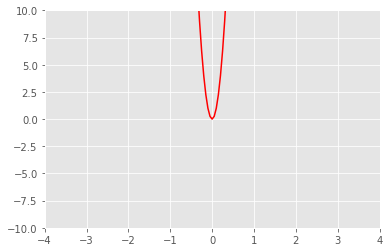

In [14]:
def double_well(x,k):
    return k*x**2

k=100.0

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, double_well(x_serie,k), 'r-')
plt.ylim(-10,10)
plt.xlim(-4,4)
plt.show()

In [28]:
x = sy.symbols('x')
g=sy.diff(k*x**2,x)
gg=sy.diff(k*x**2,x,x)
roots_diff=sy.roots(g,x)

dict

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'count',
 'index']

# Double Well (X dimension)

In [ ]:
for ii in range(mm.Platform.getNumPlatforms()):
    print(mm.Platform.getPlatform(ii).getName())

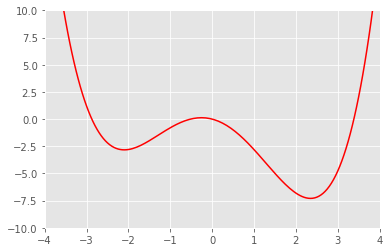

In [20]:
def double_well(x,Eo,C,m):
    return Eo*(C*x**4-x**2)+m*x

Eo=2.0
C=0.1
m=-1.0

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, double_well(x_serie,Eo,C,m), 'r-')
plt.ylim(-10,10)
plt.xlim(-4,4)
plt.show()

In [26]:
x = sy.symbols('x')
g=sy.diff(Eo*(C*x**4-x**2)+m*x,x)
gg=sy.diff(Eo*(C*x**4-x**2)+m*x,x,x)
roots_diff=sy.roots(g,x)

In [27]:
gg

2.4*x**2 - 4.0

In [ ]:


def double_well(x,Eo,C,m):
    return Eo*(C*x**4-x**2)+m*x

Eo=2.0
C=0.1
m=-1.0

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, double_well(x_serie,Eo,C,m), 'r-')
plt.ylim(-10,10)
plt.xlim(-4,4)
plt.show()def double_well(x,Eo,C,m):
    return Eo*(C*x**4-x**2)+m*x

Eo=2.0
C=0.1
m=-1.0

x_serie = np.arange(-5., 5., 0.05)

plt.plot(x_serie, double_well(x_serie,Eo,C,m), 'r-')
plt.ylim(-10,10)
plt.xlim(-4,4)
plt.show()

In [ ]:
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
friction    = 1/unit.picosecond


Eo = Eo * unit.kilocalories_per_mole/unit.angstrom**2
C  = C  * 1/unit.angstrom**2
mass = 1.0 * unit.amu 
num_degrees_of_freedom = 1

In [ ]:
step_size       = 0.001*unit.picoseconds
num_steps       = 30000
saving_period   = 100
platform_name='CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"

initial_positions = unit.Quantity(np.zeros([1,3], np.float32), unit.angstroms)

"""
T = sqrt(m/K)
timestep smaller than ~ T/10
standard deviation in each dimension sigma= (kT / K)^(1/2)
Expectation and standard deviation of the potential energy of a 3D harmonic oscillator is (3/2)kT
"""

In [ ]:
num_checks     = int(num_steps/saving_period)
times      = unit.Quantity(np.zeros([num_checks], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_checks,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_checks,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_checks], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_checks], np.float32), unit.kilocalories_per_mole)

In [ ]:
system = mm.System()
system.addParticle(mass)

if num_degrees_of_freedom==1:
    force = mm.CustomExternalForce('(K/2.0) * (x^2)')
elif num_degrees_of_freedom==2:
    force = mm.CustomExternalForce('(K/2.0) * (x^2 + y^2)')
elif num_degrees_of_freedom==3:
    force = mm.CustomExternalForce('(K/2.0) * (x^2 + y^2 + z^2)')

In [ ]:
force.addGlobalParameter('K', K)
force.addParticle(0, [])
system.addForce(force)

In [ ]:
integrator = mm.LangevinIntegrator(temperature, friction, step_size)
platform = mm.Platform.getPlatformByName(platform_name)


In [ ]:
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [ ]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

In [ ]:
for ii in range(num_checks):

    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()



In [ ]:
times

In [ ]:
positions


In [ ]:
velocities

In [ ]:
kinetic_energies

In [ ]:
potential_energies